In [774]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

## Read in data and convert types

In [775]:
df = pd.read_csv('preprocessed-data.csv')

# convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# total nan values
df.isna().sum().sum()

0

In [776]:
df_corr = df[['latitude','longitude','State','Market_Name','Local_Government','price']].copy()

market_name_dict = {x:en for en, x in enumerate(df_corr['Market_Name'].unique())}
state_dict = {x:en for en, x in enumerate(df_corr['State'].unique())}
local_government_dict = {x:en for en, x in enumerate(df_corr['Local_Government'].unique())}


df_corr['Market_Name'] = df_corr['Market_Name'].map(market_name_dict)
df_corr['State'] = df_corr['State'].map(state_dict)
df_corr['Local_Government'] = df_corr['Local_Government'].map(local_government_dict)

In [777]:
display(pd.DataFrame(df_corr.corr())['price'])
display(pd.DataFrame(df_corr.corr(method='spearman'))['price'])

latitude           -0.025368
longitude          -0.004234
State               0.000567
Market_Name        -0.033355
Local_Government   -0.013005
price               1.000000
Name: price, dtype: float64

latitude           -0.153525
longitude          -0.167992
State              -0.044269
Market_Name        -0.264915
Local_Government   -0.149497
price               1.000000
Name: price, dtype: float64

In [778]:
df['priceflag'].unique()

array(['actual', 'actual,aggregate', 'aggregate'], dtype=object)

In [779]:
# drop all agreed columns
df = df.drop(columns=['latitude','longitude','State','usdprice','currency','priceflag','Local_Government'])

df.sample(5)

,date,Market_Name,category,commodity,unit,pricetype,price,year,month,season,Inflation
1907,2013-01-15,Maiduguri,cereals and tubers,Maize (white),1KG,Wholesale,68.900000,2013,January,Dry Season,8.495518
4336,2015-03-15,Maiduguri,cereals and tubers,Sorghum (brown),1KG,Wholesale,55.000000,2015,March,Early Rainy Season,9.009435
5688,2015-08-15,Lagos,cereals and tubers,Maize (white),1KG,Wholesale,66.250000,2015,August,Peak Rainy Season,9.009435
43833,2021-10-15,Custom,cereals and tubers,Rice (local),1KG,Retail,50.000000,2021,October,Late Rainy Season,16.952846
14107,2017-06-15,Monday,cereals and tubers,Millet,1KG,Retail,17.142857,2017,June,Peak Rainy Season,16.502266


In [780]:
# Check that all prices are above zero
df[df['price']<=0]

,date,Market_Name,category,commodity,unit,pricetype,price,year,month,season,Inflation


## Date Features

Create Sin and Cos features for date 

In [781]:
# Generate seasonality features from date 

# Compute day of year
df['dayofyear'] = df['date'].dt.dayofyear

# Compute total days in the year for each date
df['daysinyear'] = df['date'].dt.is_leap_year.apply(lambda x: 366 if x else 365)

# Compute the fractional year
df['fractional_year'] = df['dayofyear'] / df['daysinyear']

# Apply sine transformation
df['sin_date'] = np.sin(2 * np.pi * df['fractional_year'])
df['cos_date'] = np.cos(2 * np.pi * df['fractional_year'])

# Drop the columns we don't need anymore
df.drop(columns=['dayofyear','daysinyear','fractional_year','month'], inplace=True)

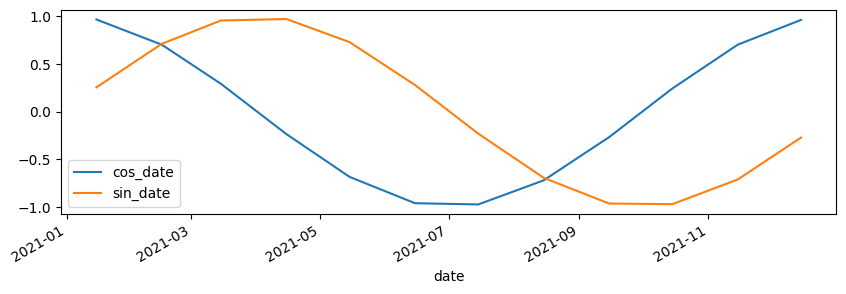

In [782]:
df_2021 = df[df['year'] == 2021]
df_2021.set_index('date', inplace=True)
df_2021[['cos_date','sin_date']].plot(figsize=(10, 3),legend=True)
plt.show()

## Units

In [783]:
# unit items
print(df[df['unit']=='Unit']['commodity'].unique())

# print unique units
print(df['unit'].unique())

['Bread']
['1KG' 'Unit' 'L' '30 pcs' '100 Tubers']


In [784]:
df[(df['unit']=='30 pcs')|(df['unit']=='Unit')].sample(10)

,date,Market_Name,category,commodity,unit,pricetype,price,year,season,Inflation,sin_date,cos_date
33222,2019-10-15,Bade (Gashua),"meat, fish and eggs",Eggs,30 pcs,Retail,1000.00,2019,Late Rainy Season,11.396422,-0.970064,0.242850
40579,2021-01-15,Potiskum,"meat, fish and eggs",Eggs,30 pcs,Retail,1300.00,2021,Dry Season,16.952846,0.255353,0.966848
23061,2018-08-15,Dandume,cereals and tubers,Bread,Unit,Retail,400.00,2018,Peak Rainy Season,12.095107,-0.693281,-0.720667
4832,2015-05-15,Mubi,cereals and tubers,Bread,Unit,Retail,140.00,2015,Early Rainy Season,9.009435,0.729558,-0.683919
51639,2020-06-15,Kaura Namoda,cereals and tubers,Bread,Unit,Retail,419.64,2020,Peak Rainy Season,13.246023,0.271234,-0.962513
34068,2019-11-15,Kaura Namoda,cereals and tubers,Bread,Unit,Retail,466.08,2019,Late Rainy Season,11.396422,-0.711657,0.702527
19149,2018-02-15,Monday,"meat, fish and eggs",Eggs,30 pcs,Retail,1150.00,2018,Dry Season,12.095107,0.711657,0.702527
49550,2023-06-15,Jakusko,"meat, fish and eggs",Eggs,30 pcs,Retail,3000.00,2023,Peak Rainy Season,19.160000,0.280231,-0.959933
15150,2017-08-15,Mubi,cereals and tubers,Bread,Unit,Retail,300.00,2017,Peak Rainy Season,16.502266,-0.693281,-0.720667
30956,2019-08-15,Bullunkutu,"meat, fish and eggs",Eggs,30 pcs,Retail,1075.00,2019,Peak Rainy Season,11.396422,-0.693281,-0.720667


In [785]:
print(len(df['commodity'].unique()))
sorted(df['commodity'].unique())

42


['Bananas',
 'Beans (niebe)',
 'Beans (red)',
 'Beans (white)',
 'Bread',
 'Cassava meal (gari, yellow)',
 'Cowpeas',
 'Cowpeas (brown)',
 'Cowpeas (white)',
 'Eggs',
 'Fish',
 'Fuel (diesel)',
 'Fuel (petrol-gasoline)',
 'Gari (white)',
 'Groundnuts',
 'Groundnuts (shelled)',
 'Maize',
 'Maize (white)',
 'Maize (yellow)',
 'Maize flour',
 'Meat (beef)',
 'Meat (goat)',
 'Milk',
 'Millet',
 'Oil (palm)',
 'Oil (vegetable)',
 'Onions',
 'Oranges',
 'Rice (imported)',
 'Rice (local)',
 'Rice (milled, local)',
 'Salt',
 'Sorghum',
 'Sorghum (brown)',
 'Sorghum (white)',
 'Spinach',
 'Sugar',
 'Tomatoes',
 'Watermelons',
 'Wheat',
 'Yam',
 'Yam (Abuja)']

In [786]:
base_commodities = [x.split(' ')[0] for x in sorted(df['commodity'].unique())]
# slice only commodities that appear mmore than once
various_commodities = [key for key, value in Counter(base_commodities).items() if value > 1]
various_commodities

['Beans',
 'Cowpeas',
 'Fuel',
 'Groundnuts',
 'Maize',
 'Meat',
 'Oil',
 'Rice',
 'Sorghum',
 'Yam']

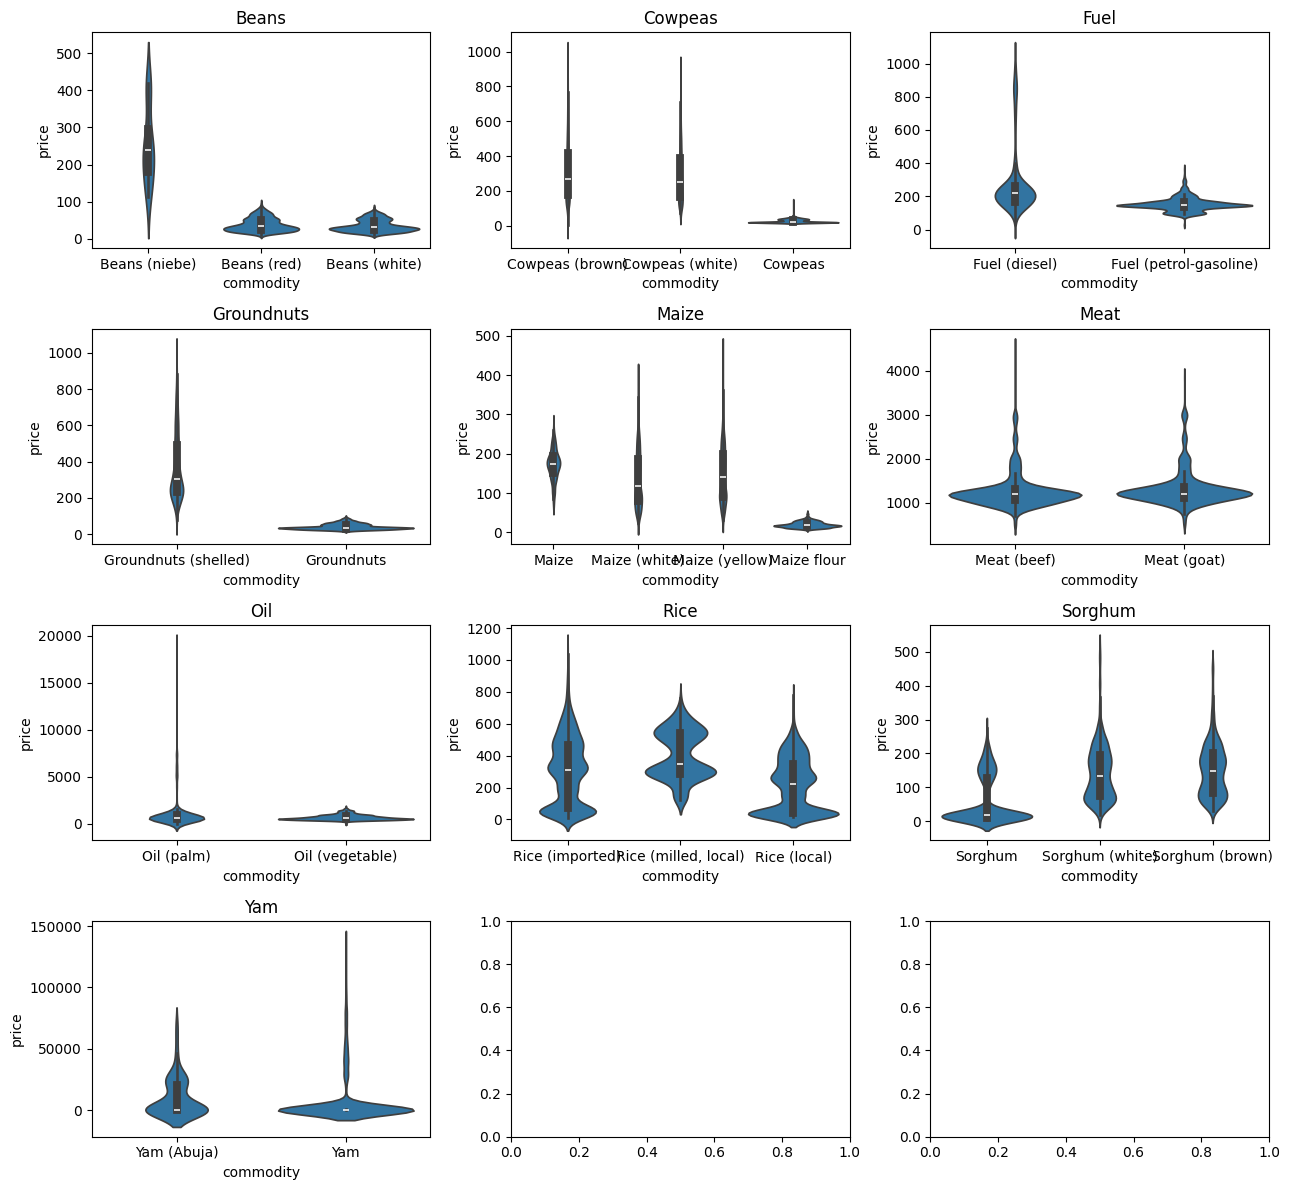

In [787]:
# plot distribution of prices for commodities that appear more than once

num_rows = len(various_commodities) // 3 + len(various_commodities) % 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, 3 * num_rows))
axes = axes.ravel()  

for i, commodity in enumerate(various_commodities):
    sns.violinplot(x='commodity', y='price', 
                   data=df[df['commodity'].str.contains(commodity)], 
                   ax=axes[i])
    axes[i].set_title(commodity) 

plt.tight_layout() 
plt.show()


In [788]:
# to prevent multicollinearity, we will rename commodities with similar distributions
commodity_groups = {'Beans (red)':'Beans (grouped)',
                    'Beans (white)':'Beans (grouped)',
                    'Cowpeas (brown)':'Cowpeas (grouped)',
                    'Cowpeas (white)': 'Cowpeas (grouped)',
                    'Maize (white)': 'Maize (grouped)',
                    'Maize (yellow)': 'Maize (grouped)',
                    'Meat (beef)': 'Meat (grouped)',
                    'Meat (goat)': 'Meat (grouped)',
                    'Rice (imported)': 'Rice (grouped)',
                    'Rice (local)': 'Rice (grouped)',
                    'Rice (milled, local)': 'Rice (grouped)',
                    'Sorghum (brown)': 'Sorghum (grouped)',
                    'Sorghum (white)': 'Sorghum (grouped)'
                    }

df['commodity'] = df['commodity'].replace(commodity_groups)

In [789]:
df.isna().sum().sum()   

0

In [790]:
df['unit'].unique(  )

array(['1KG', 'Unit', 'L', '30 pcs', '100 Tubers'], dtype=object)

In [791]:
# convert all rows in the unit column that are tubers to kgs
def tubers_to_kg(x,target):
    '''
    Yams: Assume an average weight of 1.5 kg per tuber.
    Potatoes: Assume an average weight of 0.2 kg per tuber.
    Cassava: Assume an average weight of 1 kg per tuber.
    Palm Oil: Assume an average weight of 1.123 kg per litre.
        
    Source: "LOCAL WEIGHTS AND MEASURES IN NIGERIA"
    '''
    yam_tuber = float(1.5 * 100)
    potato_tuber = float(0.2 * 100)
    cassava_tuber = float(1 * 100)
    palm_oil_litre = float(1.1)
    
    new_price = float(x['price'])
    new_unit = str(x['unit'])
    
    if 'yam' in x['commodity'].lower():
        if x['unit'] == '100 Tubers':
            new_unit = '1KG'
            new_price = new_price/float(yam_tuber)
    elif 'potato' in x['commodity'].lower():
        new_unit = '1KG'
        new_price = new_price/float(potato_tuber)
    elif 'cassava' in x['commodity'].lower():
        new_unit = '1KG'
        new_price = new_price/float(cassava_tuber)
    elif 'oil (palm)' in x['commodity'].lower():
        if x['unit'] == '1KG':
            new_unit = 'L'
            new_price = new_price/float(palm_oil_litre) 
    # return new unit and price
    if target == 'unit':
        return new_unit
    elif target == 'price':
        return round(new_price,2)
        
    
df['price'] = df.apply(tubers_to_kg,target='price', axis=1)
df['unit'] = df.apply(tubers_to_kg,target='unit', axis=1)

# print unique units
print(df['unit'].unique())
    

['1KG' 'Unit' 'L' '30 pcs']


In [792]:
df.isna().sum()

date           0
Market_Name    0
category       0
commodity      0
unit           0
pricetype      0
price          0
year           0
season         0
Inflation      0
sin_date       0
cos_date       0
dtype: int64

# Outliers

Upper Bound: 24.23945452, Total outliers: 0
Total outliers dropped: 2562, 3.9893492782734623


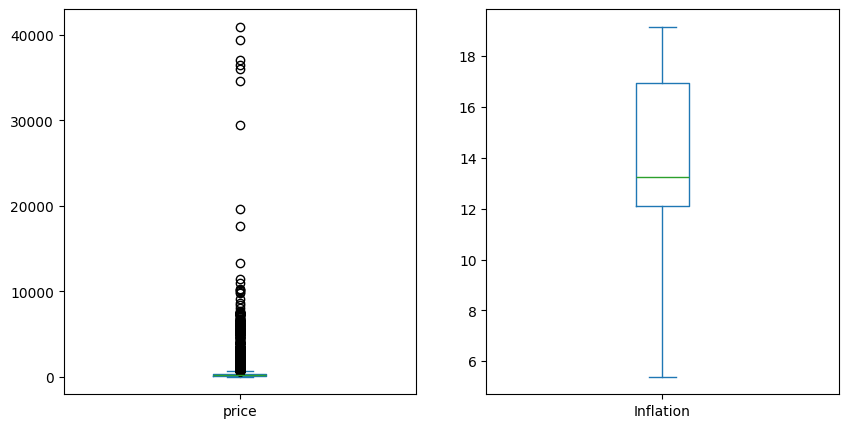

In [793]:
# IQR
Q1 = np.percentile(df['Inflation'], 25, method='midpoint')
Q3 = np.percentile(df['Inflation'], 75, method='midpoint')
IQR = Q3 - Q1

# Above Upper bound
upper = Q3 + (1.5 * IQR)
upper_array=np.array(df['Inflation']>=upper)
print(f"Upper Bound: {upper}, Total outliers: {upper_array.sum()}")

total_outliers = 0
shape_before = df.shape[0]
complete_df = []
for commodity in df['commodity'].unique():
    df_commodity = df[df['commodity']==commodity]
    for year in df_commodity['year'].unique():
        df_commodity_year = df_commodity[df_commodity['year']==year]
        # print("Analyse column: ",col)
        # IQR
        Q1 = np.percentile(df_commodity_year['price'], 25, method='midpoint')
        Q3 = np.percentile(df_commodity_year['price'], 75, method='midpoint')
        IQR = Q3 - Q1

        # Above Upper bound
        upper = Q3 + (1.5 * IQR)
        upper_array=np.array(df_commodity_year['price']>=upper)
        # print(f"\tUpper Bound: {upper}, Total outliers: {upper_array.sum()}")
        
        # remove outliers
        df_commodity_year = df_commodity_year.drop(df_commodity_year[upper_array].index)
        total_outliers = total_outliers + upper_array.sum()
        
        complete_df.append(df_commodity_year)
        
df = pd.concat(complete_df)

# plot outliers
df[['price','Inflation']].plot(kind='box', subplots=True, layout=(1,2), figsize=(10,5))
print(f"Total outliers dropped: {total_outliers}, {(total_outliers/shape_before)*100}")

## Average duplicated rows

In [794]:
total_rows = df.shape[0]
df = df.groupby(['date','Market_Name','category','commodity','unit','pricetype','year','season','Inflation','sin_date','cos_date']).mean().reset_index()

print(f"Total rows dropped: {total_rows - df.shape[0]}, {(total_rows - df.shape[0])/total_rows*100}%")

Total rows dropped: 10764, 17.4573055028463%


## Encode commodity features

In [795]:
# ordinal encode commodities with lowest price as encoding 0 and highest price as encoding x
df_commodity = df[['commodity','price']].groupby(['commodity']).mean().sort_values(by='price', ascending=True).reset_index()
# save to dictionary with market name as key and index as value
commodity_dict = dict(zip(df_commodity['commodity'],df_commodity.index))

df['commodity_ordinal'] = df['commodity'].map(commodity_dict)
df.drop(columns=['commodity'], inplace=True)

In [796]:
df.drop(columns=['unit'], inplace=True)

# Catagory Encoding

In [797]:
# ordinal encode category with lowest price as encoding 0 and highest price as encoding x
df_category = df[['category','price']].groupby(['category']).mean().sort_values(by='price', ascending=True).reset_index()
# save to dictionary with market name as key and index as value
category_dict = dict(zip(df_category['category'],df_category.index))

df['category_ordinal'] = df['category'].map(category_dict)
df.drop(columns=['category'], inplace=True)


## Price Type

In [798]:
# binary encode the pricetype column with 0 for wholesale and 1 for retail as retail is more expensive
pricetype = {'Wholesale':0, 'Retail':1 }
df['pricetype_binary'] = df['pricetype'].map(pricetype)
df.drop(columns=['pricetype'], inplace=True)

## Location features

In [799]:
# calculate which Market is the most expensive and create an ordinal catagory 
df_market = df[['price','Market_Name']].groupby(['Market_Name']).mean().sort_values(by='price',ascending=True).reset_index()
# save to dictionary with market name as key and index as value
market_dict = dict(zip(df_market['Market_Name'],df_market.index))

df['Market_Ordinal'] = df['Market_Name'].map(market_dict)
df.drop(columns=['Market_Name'], inplace=True)

In [800]:
df.sample(5)

,date,year,season,Inflation,sin_date,cos_date,price,commodity_ordinal,category_ordinal,pricetype_binary,Market_Ordinal
10045,2017-03-15,2017,Early Rainy Season,16.502266,0.956235,0.292600,27.08,6,5,1,25
39186,2021-06-15,2021,Peak Rainy Season,16.952846,0.280231,-0.959933,19.23,5,2,1,30
43332,2022-01-15,2022,Dry Season,18.847188,0.255353,0.966848,62.50,25,1,1,37
44266,2022-02-15,2022,Dry Season,18.847188,0.711657,0.702527,468.15,27,2,1,16
16820,2018-05-15,2018,Early Rainy Season,12.095107,0.729558,-0.683919,975.00,32,5,1,22


## Ordinal encode seasons

In [801]:
# check seaona order per month
df['month'] = df['date'].dt.month
df[df['year']==2022][['season','month']].drop_duplicates().sort_values(by='month')
df.drop(columns=['month'], inplace=True)

In [802]:
df_season = df[['season','price']].groupby(['season']).mean().sort_values(by='price',ascending=True).reset_index()
df_season

,season,price
0,Late Rainy Season,273.442422
1,Peak Rainy Season,286.501459
2,Dry Season,288.210148
3,Early Rainy Season,321.525612


In [803]:
# seaons dictionary
# Early rainy seaon seems to have the highest prices and will be set to 3
# Late rainy season seems to have the lowest prices and will be set to 0
season_dict = {'Dry Season':2,'Early Rainy Season':3,'Peak Rainy Season':1,'Late Rainy Season':0}

# map the seasons dictionary to the season column
df['season_ordinal'] = df['season'].map(season_dict)
df.drop(columns=['season'], inplace=True)

## Final Data set

In [804]:
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df.sample(20).sort_index()

,year,Inflation,sin_date,cos_date,price,commodity_ordinal,category_ordinal,pricetype_binary,Market_Ordinal,season_ordinal
date,,,,,,,,,,
2008-09-15,2008,11.581075,-0.964806,-0.262962,493.700,25,1,0,3,1
2012-10-15,2012,12.224241,-0.969178,0.246361,194.880,10,1,0,3,0
2016-07-15,2016,15.696813,-0.238033,-0.971257,408.920,29,6,1,32,1
2017-02-15,2017,16.502266,0.711657,0.702527,14.230,10,1,1,23,2
2017-03-15,2017,16.502266,0.956235,0.292600,16.670,6,5,1,36,3
2017-08-15,2017,16.502266,-0.693281,-0.720667,975.000,32,5,1,23,1
2017-08-15,2017,16.502266,-0.693281,-0.720667,145.360,11,1,0,10,1
2017-11-15,2017,16.502266,-0.711657,0.702527,40.000,12,0,1,26,0
2018-09-15,2018,12.095107,-0.963471,-0.267814,128.300,17,1,1,15,1


In [805]:
df = df[['year','sin_date', 'cos_date','Inflation',
       'commodity_ordinal', 'category_ordinal', 'pricetype_binary',
       'Market_Ordinal', 'season_ordinal','price']]

In [806]:
df.sort_index(inplace=True)
df.to_csv('jeroen_vanlier_final_dataset.csv', index=True)

In [808]:
df

,year,sin_date,cos_date,Inflation,commodity_ordinal,category_ordinal,pricetype_binary,Market_Ordinal,season_ordinal,price
date,,,,,,,,,,
2002-01-15,2002,0.255353,0.966848,12.876579,11,1,0,0,2,146.95
2002-01-15,2002,0.255353,0.966848,12.876579,25,1,0,0,2,337.59
2002-01-15,2002,0.255353,0.966848,12.876579,10,1,0,0,2,141.50
2002-01-15,2002,0.255353,0.966848,12.876579,23,2,0,0,2,239.07
2002-01-15,2002,0.255353,0.966848,12.876579,18,1,0,3,2,175.92
...,...,...,...,...,...,...,...,...,...,...
2023-06-15,2023,0.280231,-0.959933,19.160000,12,0,1,18,1,267.50
2023-06-15,2023,0.280231,-0.959933,19.160000,22,0,1,18,1,242.50
2023-06-15,2023,0.280231,-0.959933,19.160000,15,0,1,18,1,166.66
